# РГР 2

## 1. Датасет

Для работы был выбран датасет [European Ski Resorts](https://www.kaggle.com/datasets/thomasnibb/european-ski-resorts/data)

**Экзогенные переменные**
1. Country - страна (One-Hot Encoding)
2. HighestPoint - высшая точка курорта (метры)
3. TotalSlope - общая протяженность склонов (километры)
4. Snowparks - наличие сноупарков (0/1)
5. NightSki - наличие ночного катания (0/1)
6. TotalLifts - количество подъемников
7. LiftCapacity - пропускная способность подъемников (человек в час)
8. SnowCannons - количество снежных пушек

**Эндогенная переменная**
- DayPassPriceAdult - цена дневного ски-пасса для взрослого (евро)

In [8]:
import kagglehub
from kagglehub import KaggleDatasetAdapter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import norm, pearsonr, shapiro, normaltest
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson
import warnings

warnings.filterwarnings('ignore')

file_path = "European_Ski_Resorts.csv"

# Load the latest version
loaded_df = kagglehub.load_dataset(
    KaggleDatasetAdapter.PANDAS,
    "thomasnibb/european-ski-resorts",
    file_path,
    # Provide any additional arguments like
    # sql_query or pandas_kwargs. See the
    # documenation for more information:
    # https://github.com/Kaggle/kagglehub/blob/main/README.md#kaggledatasetadapterpandas
)

print("First 5 records:", loaded_df.head())

First 5 records:    Unnamed: 0                                             Resort  \
0           1                              Alpendorf (Ski amedé)   
1           2  Soldeu-Pas de la Casa/​Grau Roig/​El Tarter/​C...   
2           3                              Oberau (Wildschönau)   
3           4                                     Dachstein West   
4           5                                        Rosa Khutor   

           Country  HighestPoint  LowestPoint  DayPassPriceAdult  \
0          Austria          1980          740                 52   
1          Andorra          2640         1710                 47   
2          Austria          1130          900                 30   
3          Austria          1620          780                 42   
4  Southern Russia          2320          940                 22   

   BeginnerSlope  IntermediateSlope  DifficultSlope  TotalSlope Snowparks  \
0             30                 81               4         115       Yes   
1          

In [19]:
df = loaded_df
columns_to_keep = [
    "Country", "HighestPoint", "TotalSlope", "Snowparks",
    "NightSki", "TotalLifts", "LiftCapacity", "SnowCannons",
    "DayPassPriceAdult"
]

noise_percentage = np.random.uniform(-0.4, 0.4, len(df))
df['LiftCapacity'] = (df['LiftCapacity'] * (1 + noise_percentage))

df = df[columns_to_keep]
df = df[df["DayPassPriceAdult"] != 0]

# Фильтруем по странам
countries_to_keep = ["Austria", "France", "Switzerland", "Italy"]
df = df[df["Country"].isin(countries_to_keep)]

# Преобразуем Snowparks и NightSki в 0 и 1
df["Snowparks"] = df["Snowparks"].apply(lambda x: 1 if x=="Yes" else 0)
df["NightSki"] = df["NightSki"].apply(lambda x: 1 if x=="Yes" else 0)

# Применяем One-Hot Encoding для столбца Country
df = pd.get_dummies(df, columns=["Country"], drop_first=False, dtype=np.int64)

print(df.head())

    HighestPoint  TotalSlope  Snowparks  NightSki  TotalLifts  LiftCapacity  \
0           1980         115          1         0          49  93006.052674   
2           1130           2          0         0           2   1178.124560   
3           1620          51          1         1          36  43182.997895   
10          1785          24          0         0           8  12160.846344   
12          1750          20          1         1          15   3031.414088   

    SnowCannons  DayPassPriceAdult  Country_Austria  Country_France  \
0           600                 52                1               0   
2             0                 30                1               0   
3           163                 42                1               0   
10            0                 19                0               1   
12           46                 34                0               0   

    Country_Italy  Country_Switzerland  
0               0                    0  
2               

In [20]:
from sklearn.preprocessing import StandardScaler

columns_to_scale = ["HighestPoint", "TotalSlope", "TotalLifts", "LiftCapacity", "SnowCannons"]
scaler = StandardScaler()
df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])

print(df.head())

    HighestPoint  TotalSlope  Snowparks  NightSki  TotalLifts  LiftCapacity  \
0      -0.493911    0.078594          1         0    0.521224      0.887413   
2      -1.838954   -0.824631          0         0   -0.851397     -0.722775   
3      -1.063576   -0.432967          1         1    0.141563      0.013774   
10     -0.802480   -0.648782          0         0   -0.676169     -0.530195   
12     -0.857864   -0.680755          1         1   -0.471736     -0.690278   

    SnowCannons  DayPassPriceAdult  Country_Austria  Country_France  \
0      0.759971                 52                1               0   
2     -0.579764                 30                1               0   
3     -0.215803                 42                1               0   
10    -0.579764                 19                0               1   
12    -0.477051                 34                0               0   

    Country_Italy  Country_Switzerland  
0               0                    0  
2               

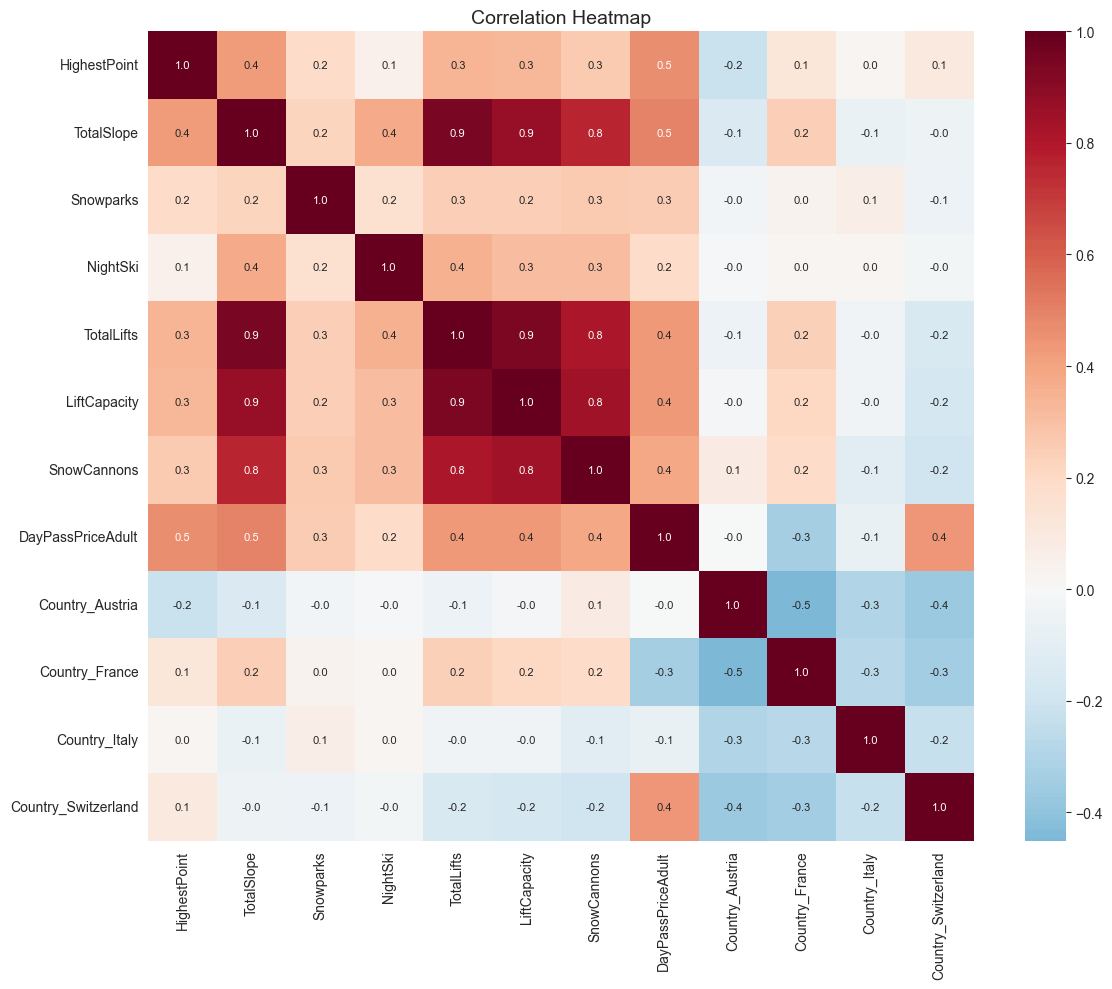

In [21]:
import seaborn as sns

plt.figure(figsize=(12, 10))
heatmap = sns.heatmap(df.corr(),
                      annot=True,
                      fmt=".1f",
                      cmap="RdBu_r",
                      center=0,
                      annot_kws={"size": 8})
plt.title("Correlation Heatmap", fontsize=14)
plt.tight_layout()
plt.show()

## 2. КЛММР

### Построение КЛММР

$X_i = \left(\begin{array} &
1 & x_1^{(1)} & ... & x_1^{(p)} \\
1 & x_2^{(1)} & ... & x_2^{(p)} \\
... & ... & ... & ... \\
1 & x_n^{(1)} & ... & x_n^{(p)}
\end{array}\right)$

$Y=(y_1,y_2,...,y_n)^T, \varepsilon=(\varepsilon_1, \varepsilon_2, ..., \varepsilon_n)^T, \theta=(\theta_0, \theta_1, ..., \theta_p)^T$

$Y=X \cdot \theta + \varepsilon$

In [57]:
# Формируем формулу для регрессии
formula = "DayPassPriceAdult ~ HighestPoint + TotalSlope + Snowparks + NightSki + TotalLifts + LiftCapacity + SnowCannons + Country_Austria + Country_France + Country_Switzerland + Country_Italy"

# Строим модель
model = ols(formula, data=df).fit()

# Выводим результаты
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:      DayPassPriceAdult   R-squared:                       0.684
Model:                            OLS   Adj. R-squared:                  0.672
Method:                 Least Squares   F-statistic:                     57.05
Date:                Wed, 26 Nov 2025   Prob (F-statistic):           3.17e-60
Time:                        22:03:54   Log-Likelihood:                -873.19
No. Observations:                 275   AIC:                             1768.
Df Residuals:                     264   BIC:                             1808.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              33.6639    

### Полученные коэффициенты КЛММР

Видно, скипасс на курортах Швейцарии самый дорогой, а на курортах Франции самый дешевый.

Среди количественных факторов наибольшее влияние на цену скипасса оказывает пропускная способность подъемников (LiftCapacity) и количество подъемников (TotalLifts). Причем влияние пропускной способности подъемников положительное, а количество подъемников отрицательное.

Наличие сноупарка (Snowparks) добаляет к цене скипасса около 3.4 евро, а ночное катание (NightSki) не оказывает значимого влияния.

In [58]:
model.params

Intercept              33.663868
HighestPoint            2.752988
TotalSlope              2.749284
Snowparks               3.365578
NightSki               -0.059314
TotalLifts             -7.266930
LiftCapacity            9.359293
SnowCannons             0.132707
Country_Austria         9.172335
Country_France          0.581153
Country_Switzerland    17.457032
Country_Italy           6.453348
dtype: float64

### t-тест для проверки значимости коэффициентов регрессии

$H_0: \hat{b_j}=0$

$H_1: \hat{b_j} \ne 0$

$t_{b_j} = \dfrac{\hat{b_j}}{\sqrt{\frac{\sum \varepsilon_i^2}{n - p - 1}z_{jj}}}$, где $z_{jj}$ - диагональный j-й элемент матрицы $(X^TX)^{-1}$

$t_{b_j}$ ~ $t_{\nu=n - p - 1, \alpha}$

Если $|t_{набл}| > t_{кр}$, то отвергаем $H_0$ на уровне значимости $\alpha=0.05$


In [59]:
import pandas as pd
from scipy.stats import t

# Извлекаем t-статистику из модели
t_values = model.tvalues

# Число наблюдений и параметров
n = model.nobs  # количество наблюдений
p = len(model.params) - 1  # количество предикторов (без учета константы)

# Степени свободы
nu = int(n - p - 1)

# Критическое значение t при alpha=0.05 (двусторонний тест)
t_critical = t.ppf(1 - 0.05 / 2, df=nu)

# Формируем таблицу
results = pd.DataFrame({
    "t_наблюдаемое": t_values,
    "t_критическое": [t_critical] * len(t_values),
    "Значимость": ["Да" if abs(t_val) > t_critical else "-" for t_val in t_values]
})

results

,t_наблюдаемое,t_критическое,Значимость
Intercept,48.330151,1.969025,Да
HighestPoint,6.632907,1.969025,Да
TotalSlope,2.181925,1.969025,Да
Snowparks,3.592022,1.969025,Да
NightSki,-0.072890,1.969025,-
TotalLifts,-2.992484,1.969025,Да
LiftCapacity,3.748331,1.969025,Да
SnowCannons,0.187980,1.969025,-
Country_Austria,14.469818,1.969025,Да
Country_France,0.935893,1.969025,-


### F-тест для проверки значимости модели в целом

$H_0: D_{факт}=D_{ост}$

$H_1: D_{факт} > D_{ост}$

$F_{набл}=\dfrac{D_{факт}}{D_{ост}}=\dfrac{\sum \dfrac{(\hat{y_i}-\overline{y})^2}{p}}{\sum \dfrac{\varepsilon_i^2}{n-p-1}}$

$F_{кр}=F_{\nu_1=m, \nu_2=n-m-1, \alpha}$

Если $F_{набл} > F_{кр}$, то отвергаем $H_0$ на уровне значимости $\alpha=0.05$

In [61]:
from scipy.stats import f

# Число наблюдений и параметров
n = model.nobs  # количество наблюдений
p = len(model.params) - 1  # количество предикторов (без учета константы)

# Степени свободы
nu1 = p  # числитель (количество предикторов)
nu2 = int(n - p - 1)  # знаменатель (остаточные степени свободы)

# F-наблюдаемое
f_observed = model.fvalue

# F-критическое значение при alpha=0.05
f_critical = f.ppf(1 - 0.05, dfn=nu1, dfd=nu2)

# Вердикт
verdict = "Модель значима" if f_observed > f_critical else "Модель не значима"

# Вывод результатов
print(f"F-наблюдаемое: {f_observed}")
print(f"F-критическое: {f_critical}")
print(f"Вердикт: {verdict}")

F-наблюдаемое: 57.053521948041606
F-критическое: 1.8251715542100644
Вердикт: Модель значима


### Средняя ошибка аппроксимации (Mean Approximation Error, MAPE)

$MAPE=\dfrac{1}{n}\sum \limits_{i=1}^n \left|\dfrac{y_i - \hat{y_i}}{y_i}\right| \cdot 100\%$

In [65]:
# Предсказанные значения
y_pred = model.fittedvalues

# Истинные значения
y_true = df["DayPassPriceAdult"]

# Расчёт MAPE
mape = (abs((y_true - y_pred) / y_true).mean()) * 100

print(f"MAPE: {mape:.2f}%")

MAPE: 11.18%


### Коэффициент детерминации

$R^2=1-\dfrac{\sum \varepsilon_i^2}{\sum (y_i - \overline{y})^2}$

$R_{норм}^2=1-(1-R^2)\cdot\dfrac{n-1}{n-m-1}$

In [66]:
r_squared = model.rsquared

r_squared_adj = model.rsquared_adj

print(f"R^2: {r_squared:.4f}")
print(f"R_норм^2: {r_squared_adj:.4f}")

R^2: 0.6837
R_норм^2: 0.6717


## 3. Проверка на мультиколлинеарность

### Тест Фаррара-Глобера

$H_0: \det{\tilde R} = 1$

$H_1: \det{\tilde R} \ne 1$

$\tilde R$ - корреляционная матрица независимых переменных

$\chi^2_{набл} = -\left(n-1-\dfrac{2p+5}{6}\right) \cdot \ln{\left|\det{\tilde R}\right|}$

$\chi^2_{кр} = \chi^2_{\nu=\frac{p(p-1)}{2}, \alpha}$

Если $\chi^2_{набл} > \chi^2_{кр}$, то отвергаем $H_0$ на уровне значимости $\alpha=0.05$ и доказываем наличие мультиколлинеарности

In [80]:
from numpy.linalg import det
from scipy.stats import chi2

# Вычисляем корреляционную матрицу независимых переменных
X = df.drop(columns=["DayPassPriceAdult"])
correlation_matrix = X.corr()

# Определитель корреляционной матрицы
det_corr_matrix = det(correlation_matrix)

# Число наблюдений и предикторов
n = len(df)
p = X.shape[1]

# Наблюдаемое значение статистики
chi2_observed = -(n - 1 - (2 * p + 5) / 6) * np.log(det_corr_matrix)

# Критическое значение
degrees_of_freedom = p * (p - 1) / 2
chi2_critical = chi2.ppf(1 - 0.05, df=degrees_of_freedom)

# Вердикт
verdict = "Мультиколлинеарность есть" if chi2_observed > chi2_critical else "Мультиколлинеарности нет"

# Вывод результатов
print(f"Chi^2 наблюдаемое: {chi2_observed:.4f}")
print(f"Chi^2 критическое: {chi2_critical:.4f}")
print(f"Вердикт: {verdict}")

Chi^2 наблюдаемое: 12228.4047
Chi^2 критическое: 73.3115
Вердикт: Мультиколлинеарность есть


## 4. Устранение мультиколлинеарности методом включения

### Метод включения

1. В модель добавляют 1 переменную $x_k$ которая имеет наибольший $|r_{y,x_k}|$
2. Вычисляют все $F_{x_i}$ для оставшихся переменных $x_i, i \ne k$, и включают в модель ту переменную, у которой $F_{x_i} = max$.
3. Отанавливаемся при достижении заданного числа переменных в модели или при $F_{x_i} < F_{порог}$ для всех оставшихся переменных.

$F_{x_i}=\dfrac{R^2_{yx_1...x_i...x_p}-R^2_{yx_1...x_{i-1}x_{i+1}...x_p}}{1-R^2_{yx_1...x_i...x_p}}\cdot\dfrac{n-m-1}{1}$

In [99]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import numpy as np
import pandas as pd

# Задаем порог F
f_threshold = 10

# Разделяем данные на X и y
X = df.drop(columns=["DayPassPriceAdult"])
y = df["DayPassPriceAdult"]

# Считаем корреляцию с зависимой переменной
correlations = X.corrwith(y).abs()

# Сортируем признаки по убыванию корреляции
sorted_features = correlations.sort_values(ascending=False).index.tolist()

# Инициализируем модель и переменные
selected_features = []
remaining_features = sorted_features.copy()
current_r2 = 0

while remaining_features:
    f_values = {}
    for feature in remaining_features:
        # Формируем временный набор признаков
        temp_features = selected_features + [feature]
        X_temp = X[temp_features]

        # Строим модель
        model = LinearRegression().fit(X_temp, y)
        new_r2 = r2_score(y, model.predict(X_temp))

        # Вычисляем F-статистику
        f_value = ((new_r2 - current_r2) / (1 - new_r2)) * (len(y) - len(temp_features) - 1)
        f_values[feature] = f_value

    # Находим признак с максимальным F
    best_feature = max(f_values, key=f_values.get)
    best_f_value = f_values[best_feature]

    # Проверяем порог F
    if best_f_value > f_threshold:
        selected_features.append(best_feature)
        remaining_features.remove(best_feature)
        current_r2 = r2_score(y, LinearRegression().fit(X[selected_features], y).predict(X[selected_features]))
    else:
        break

# Строим финальную модель
final_model = LinearRegression().fit(X[selected_features], y)

# Выводим коэффициенты модели
coefficients = pd.DataFrame({
    "Признак": ["Intercept"] + selected_features,
    "Коэффициент": [final_model.intercept_] + list(final_model.coef_)
})

coefficients

,Признак,Коэффициент
0,Intercept,41.974657
1,TotalSlope,2.563664
2,Country_France,-7.622042
3,Country_Switzerland,9.300167
4,HighestPoint,2.647976
5,LiftCapacity,10.018282
6,Snowparks,3.240487
7,TotalLifts,-7.592934


## 5. Уравнение регрессии на главные компоненты

## Метод главных компонент

Первая главная компонента: нормированная + центрированная система показателей, обладающая наибольшей дисперсией среди прочих нормированных + центрированных линейных комбинаций исходных переменных.

K-ая главная компонента: нормированная + центрированная система показателей, обладающая наибольшей дисперсией среди прочих нормированных + центрированных линейных комбинаций исходных переменных, ортогональная всем предыдущим главным компонентам.

**Алгоритм**
1. Центрирование и нормирование исходных данных $X_ц$
2. Считаем собственные числа у $(X_ц^TX_ц)$
3. Упорядочиваем их $\lambda_1 \ge \lambda_2 \ge ... \ge \lambda_p$
4. Для каждого собственного числа находим собственный вектор $l_1, ..., l_p$
5. Формируем матрицу $L=(l_1, l_2, ..., l_p)$ -- вектора являются строками матрицы
6. $Z = L \cdot X_ц$ -- вектор главных компонент
7. Строим регрессию $Y$ на $Z$

In [85]:
from sklearn.decomposition import PCA
import pandas as pd

# Разделяем данные на X
X = df.drop(columns=["DayPassPriceAdult"])

# Применяем PCA
pca = PCA()
pca.fit(X)

# Собственные числа (дисперсии главных компонент)
eigenvalues = pca.explained_variance_

# Вклад в суммарную дисперсию
explained_variance_ratio = pca.explained_variance_ratio_

# Накопленный вклад первых главных компонент
cumulative_variance = explained_variance_ratio.cumsum()

# Формируем таблицу
pca_table = pd.DataFrame({
    "Главная компонента": [f"z{i+1}" for i in range(len(eigenvalues))],
    "Собственное число": eigenvalues,
    "Вклад в дисперсию": explained_variance_ratio,
    "Накопленный вклад": cumulative_variance
})

pca_table

,Главная компонента,Собственное число,Вклад в дисперсию,Накопленный вклад
0,z1,3.889183,0.632428,0.632428
1,z2,0.885126,0.143932,0.776360
2,z3,0.335637,0.054579,0.830939
3,z4,0.266910,0.043403,0.874341
4,z5,0.202618,0.032948,0.907289
5,z6,0.198245,0.032237,0.939526
6,z7,0.173759,0.028255,0.967782
7,z8,0.136264,0.022158,0.989940
8,z9,0.050573,0.008224,0.998164
9,z10,0.011293,0.001836,1.000000


In [87]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
import pandas as pd

# Разделяем данные на X и y
X = df.drop(columns=["DayPassPriceAdult"])
y = df["DayPassPriceAdult"]

# Применяем PCA
pca = PCA()
X_pca = pca.fit_transform(X)

cumulative_variance = pca.explained_variance_ratio_.cumsum()
n_components = (cumulative_variance <= 0.85).sum() + 1

# Применяем PCA с выбранным числом компонент
pca = PCA(n_components=n_components)
X_reduced = pca.fit_transform(X)

# Строим регрессию на главные компоненты
model = LinearRegression().fit(X_reduced, y)

# Формируем уравнение регрессии
coefficients = pd.DataFrame({
    "Главная компонента": [f"z{i+1}" for i in range(n_components)],
    "Коэффициент": model.coef_
})

intercept = model.intercept_

print(f"Свободный член: {intercept}")
coefficients

Свободный член: 44.345454545454544


,Главная компонента,Коэффициент
0,z1,2.566355
1,z2,3.052232
2,z3,2.225992
3,z4,-9.543789


In [88]:
from sklearn.metrics import r2_score, mean_absolute_percentage_error

# Предсказанные значения
y_pred = model.predict(X_reduced)

# Истинные значения
y_true = y

# Расчёт R^2
r_squared = r2_score(y_true, y_pred)

# Расчёт MAPE
mape = mean_absolute_percentage_error(y_true, y_pred) * 100

print(f"R^2: {r_squared:.4f}")
print(f"MAPE: {mape:.2f}%")

R^2: 0.5624
MAPE: 13.00%


## 6. Частые уравнения регрессии

$y=b_0+\sum_{i=1}^pb_ix_i+\varepsilon$

$
\begin{cases}
y_{x_1\cdot x_2,x_3,...,x_p}=f(x_1) \\
y_{x_2\cdot x_1,x_3,...,x_p}=f(x_2) \\
... \\
y_{x_p\cdot x_1,x_2,...,x_{p-1}}=f(x_p)
\end{cases}
$

$
\begin{cases}
y_{x_1\cdot x_2,x_3,...,x_p}=a+b_1\cdot x_1 + b_2\cdot \overline{x_2} + ... + b_p \cdot \overline{x_p} \\
y_{x_2\cdot x_1,x_3,...,x_p}=a+b_2\cdot x_2 + b_1\cdot \overline{x_1} + ... + b_p \cdot \overline{x_p} \\
... \\
y_{x_p\cdot x_1,x_2,...,x_{p-1}}=a+b_p\cdot x_p + b_1\cdot \overline{x_1} + b_2\cdot \overline{x_2} + ... + b_{p-1} \cdot \overline{x_{p-1}}
\end{cases}
$

$
\begin{cases}
y_{x_1\cdot x_2,x_3,...,x_p} = A_1 + b_1x_1 \\
y_{x_2\cdot x_1,x_3,...,x_p} = A_2 + b_2x_2 \\
... \\
y_{x_p\cdot x_1,x_2,...,x_{p-1}}= A_3 + b_px_p
\end{cases}
$

Частный коэффициент эластичности
$E_{y_{x_i}}=b_i\cdot\dfrac{x_i}{\hat{y_{x_1\cdot x_1x_2...x_{i-1}x_{i+1}...x_p}}}$

In [110]:
import pandas as pd
import numpy as np

# Создаем вектор средних значений XM
XM = df[selected_features].mean()

# Таблица для хранения результатов
results = pd.DataFrame(columns=["y", "A", "b"])

# Вычисляем A_i и заполняем таблицу
for feature in selected_features:
    XM_modified = XM.copy()
    XM_modified[feature] = 0  # Обнуляем текущий признак
    A_i = final_model.predict([XM_modified])  # Предсказание модели с модифицированным XM
    b_i = coef_dict[feature]  # Коэффициент модели для текущего признака

    # Добавляем результат в таблицу
    results = pd.concat([results, pd.DataFrame({"y": [feature], "A": [A_i[0]], "b": [b_i]})], ignore_index=True)

results

,y,A,b
0,TotalSlope,44.345455,2.563664
1,Country_France,46.618209,-7.622042
2,Country_Switzerland,42.282508,9.300167
3,HighestPoint,44.345455,2.647976
4,LiftCapacity,44.345455,10.018282
5,Snowparks,41.764848,3.240487
6,TotalLifts,44.345455,-7.592934


In [114]:
# Таблица для хранения частных коэффициентов эластичности
elasticity_results = pd.DataFrame(columns=["y", "Эластичность"])

# Вычисляем частные коэффициенты эластичности
for feature in selected_features:
    b_i = results.loc[results["y"] == feature, "b"].values[0]  # Коэффициент b
    A_i = results.loc[results["y"] == feature, "A"].values[0]  # Коэффициент A
    mean_x = XM[feature]
    mean_y = XM[feature] * b_i + A_i

    elasticity = b_i * (mean_x / mean_y) * 100  # Частный коэффициент эластичности

    # Добавляем результат в таблицу
    elasticity_results = pd.concat(
        [elasticity_results, pd.DataFrame({"y": [feature], "Эластичность": [elasticity]})],
        ignore_index=True
    )

elasticity_results

,y,Эластичность
0,TotalSlope,-1.493721e-16
1,Country_France,-5.125112e+00
2,Country_Switzerland,4.651990e+00
3,HighestPoint,1.079992e-15
4,LiftCapacity,2.043006e-15
5,Snowparks,5.819325e+00
6,TotalLifts,-0.000000e+00


Видно, что при неизменных остальных факторах, наибольший эффект на цену скипасса оказывает пропускная способность подъемников (LiftCapacity) и их количество (TotalLifts). Причем эффект противоположный: увеличение пропускной способности подъемников ведет к увеличению цены скипасса, а увеличение количества подъемников ведет к снижению цены скипасса.

## 7. Частные коэффициенты корреляции
$
r_{yx_i \cdot x_1 x_2 \ldots x_p} =
\frac{r_{yx_i x_1 x_2 \ldots x_{p-1}} - r_{yx_p x_1 x_2 \ldots x_{p-1}} \cdot r_{x_i x_p x_1 x_2 \ldots x_{p-1}}}
{\sqrt{(1 - r_{yx_p x_1 x_2 \ldots x_{p-1}}^2) \cdot (1 - r_{x_i x_p x_1 x_2 \ldots x_{p-1}}^2)}}
$

In [115]:
import pandas as pd
import numpy as np

# Вычисляем корреляционную матрицу
correlation_matrix = df[selected_features + ["DayPassPriceAdult"]].corr()

# Таблица для хранения частных коэффициентов корреляции
partial_correlations = pd.DataFrame(index=selected_features, columns=["Partial Correlation"])

# Вычисляем частные коэффициенты корреляции
for feature in selected_features:
    r_yx_i = correlation_matrix.loc["DayPassPriceAdult", feature]
    r_yx_p = correlation_matrix.loc["DayPassPriceAdult", selected_features[-1]]
    r_x_i_x_p = correlation_matrix.loc[feature, selected_features[-1]]

    numerator = r_yx_i - r_yx_p * r_x_i_x_p
    denominator = np.sqrt((1 - r_yx_p**2) * (1 - r_x_i_x_p**2))

    partial_correlation = numerator / denominator
    partial_correlations.loc[feature, "Partial Correlation"] = partial_correlation

print(partial_correlations)

                    Partial Correlation
TotalSlope                     0.284112
Country_France                -0.500991
Country_Switzerland            0.573402
HighestPoint                    0.37508
LiftCapacity                   0.168136
Snowparks                      0.169631
TotalLifts                          NaN


In [123]:
def R_cor(dff: pd.DataFrame):
    ra = np.array(dff.corr())
    return np.sqrt(1 - np.linalg.det(ra) / np.linalg.det(ra[1:, 1:]))
def r_cor(dff, feature):
    return np.sqrt(1 - (1 - R_cor(dff)) / (1 - R_cor(dff.drop(columns=[feature]))))

partial_correlations_v2 = pd.DataFrame(index=selected_features, columns=["pc"])
for feature in selected_features:
    partial_correlations_v2.loc[feature, "pc"] = r_cor(df[["DayPassPriceAdult"] + selected_features], feature)

print(partial_correlations_v2)

                           pc
TotalSlope           0.131825
Country_France       0.490931
Country_Switzerland  0.513394
HighestPoint         0.386608
LiftCapacity         0.275702
Snowparks            0.219572
TotalLifts           0.200188


При неизменных остальных факторах наибольший эффект на цену скипасса оказывает расположение курорта в Швейцарии и Франции. Среди количественных факторов наибольший эффект оказывают пропускная способность подъемников (LiftCapacity) и наивысшая точка курорта (HighestPoint).

## 8. Построение нелинейной модели

In [127]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_percentage_error

# Разделяем данные на X и y
X = df.drop(columns=["DayPassPriceAdult"])
y = df["DayPassPriceAdult"]

# Стандартизация данных
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Линейная модель
linear_model = LinearRegression().fit(X_scaled, y)
y_pred_linear = linear_model.predict(X_scaled)

# Логарифмируем данные для степенной модели
X_log = np.log(X + 1)  # Добавляем 1, чтобы избежать логарифма 0
y_log = np.log(y + 1)

# Стандартизация логарифмированных данных
X_log_scaled = scaler.fit_transform(X_log)

# Степенная модель (линейная регрессия на логарифмах)
power_model = LinearRegression().fit(X_log_scaled, y_log)
y_pred_power = np.exp(power_model.predict(X_log_scaled)) - 1  # Обратное преобразова��ие

# Вычисляем метрики качества
r2_linear = r2_score(y, y_pred_linear)
mape_linear = mean_absolute_percentage_error(y, y_pred_linear) * 100

r2_power = r2_score(y, y_pred_power)
mape_power = mean_absolute_percentage_error(y, y_pred_power) * 100

# Выводим результаты
print(f"Линейная модель: R^2 = {r2_linear:.4f}, MAPE = {mape_linear:.2f}%")
print(f"Степенная модель: R^2 = {r2_power:.4f}, MAPE = {mape_power:.2f}%")

Линейная модель: R^2 = 0.6837, MAPE = 11.18%
Степенная модель: R^2 = 0.6662, MAPE = 10.30%
